# Random forest machine learning classification of leaf microCT data
#### Semi-automated segmentation of 3D microCT data into multiple classes: (1) background, (2) veins, (3) mesophyll cells, (4) intercellular airspace

#### To-do:
* Incorporate thresholding based on two user provided ranges for the grid and phase reconstructed images
* Test with bundle sheath segmented separately from veins

#### Open questions:

#### Last edited by: J. Mason Earles 
#### Date: 12/01/2017

In [1]:
# Import libraries
import os
import sklearn as skl
import skimage.io as io
from skimage import img_as_int, img_as_ubyte, img_as_float
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import RFLeafSeg # reload(RFLeafSeg)
from scipy import misc
from skimage.util import invert
from skimage import transform
from sklearn.metrics import confusion_matrix

### Image Loading and Pre-processing

In [ ]:
# Load binary grid+phase rec image
# This should be modified in future versions to generate thresholded images based on user input threshold ranges
bin_test = io.imread('forBeth/V_champ_phasegrid_IAS.tif')

# Invert image
bin_test_invert = invert(bin_test)

# Downsample to 25%
bin_test_invert = transform.rescale(bin_test_invert, 0.25)

In [ ]:
# Generate/load local thickness stack

# Uncomment as needed
# local_thick = RFLeafSeg.local_thickness(bin_test_invert)
# local_thick_upscale = transform.rescale(local_thick, 4, mode='reflect')

# # Write as a tif file
# io.imsave('local_thick_upscale.tif', local_thick_upscale)

# Load local thickness stack, if already generated
local_thick_upscale = io.imread('local_thick_upscale.tif')

In [3]:
# Read gridrec, phaserec, and label tif stacks
gridrec_stack = io.imread('forBeth/V_champ_gridrec.tif')
phaserec_stack = io.imread('forBeth/V_champ_phaserec.tif')
label_stack = np.rollaxis(io.imread('forBeth/label_stack.tif'),2,0)
LocalThickness_CellVeins = local_thick_upscale

# Match array dimensions to correct for loss due to downsampling
gridrec_stack, local_thick_upscale = RFLeafSeg.match_array_dim(gridrec_stack,local_thick_upscale)
phaserec_stack, local_thick_upscale = RFLeafSeg.match_array_dim(phaserec_stack,local_thick_upscale)
label_stack, local_thick_upscale = RFLeafSeg.match_array_dim(label_stack,local_thick_upscale)

In [ ]:
# Plot some of the images to make sure everything looks correct
for i in range(0,4):
    io.imshow(label_stack[i,:,:])
    io.show()

for i in [55,99,160,248]:    
    io.imshow(LocalThickness_CellVeins[i,:,:])
    io.show()
    
for i in [55,99,160,248]:    
    io.imshow(phaserec_stack[i,:,:], cmap='gray')
    io.show()

print(label_stack.shape)
print(gridrec_stack.shape)

In [ ]:
# Check shapes of stacks to make ensure that they match
print(gridrec_stack.shape)
print(phaserec_stack.shape)
print(label_stack.shape)
print(LocalThickness_CellVeins.shape)

In [22]:
# Define image subsets for training and testing
gridphase_train_slices_subset = [55] # 55 for training of Vitis champ.
gridphase_test_slices_subset = [99] # 99, 160 and 248 for testing of Vitis champ.
label_train_slices_subset = [0] # corresponding slice from the label stack
label_test_slices_subset = [1] # corresponding slice from the label stack

In [23]:
# Generate training and testing feature layer array
FL_train_transverse = RFLeafSeg.GenerateFL2(gridrec_stack, phaserec_stack, LocalThickness_CellVeins, gridphase_train_slices_subset, "transverse")
FL_test_transverse = RFLeafSeg.GenerateFL2(gridrec_stack, phaserec_stack, LocalThickness_CellVeins, gridphase_test_slices_subset, "transverse")

In [24]:
# Load and encode label image vectors
Label_train_transverse = RFLeafSeg.LoadLabelData(label_stack, label_train_slices_subset, "transverse")
Label_test_transverse = RFLeafSeg.LoadLabelData(label_stack, label_test_slices_subset, "transverse")

In [98]:
# Check the dimensions of the feature array and label vector to ensure that they are the same dimensions
print(FL_train_transverse.shape)
print(Label_train_transverse.shape)

(858240, 36)
(858240,)


### Train model

In [14]:
# Define Random Forest classifier parameters and fit model
rf_transverse = RandomForestClassifier(n_estimators=100, verbose=True, oob_score=True, n_jobs=4, warm_start=False) #, class_weight="balanced")
rf_transverse = rf_transverse.fit(FL_train_transverse, Label_train_transverse)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.2min finished


In [99]:
# Save model to disk # This can be a pretty large file -- ~2 Gb
import pickle
filename = 'RF_Vitus_champ_model.sav'
pickle.dump(rf_transverse, open(filename, 'wb'))

#load the model from disk
#rf = pickle.load(open(filename, 'rb'))

### Examine prediction metrics on training dataset

In [15]:
# Print out of bag precition accuracy
print('Our OOB prediction of accuracy for is: {oob}%'.format(oob=rf_transverse.oob_score_ * 100))

Our OOB prediction of accuracy for transverse is: 99.91575783%


In [16]:
# Print feature layer importance
# See RFLeafSeg module for corresponding feature layer types
feature_layers = range(0,len(rf_transverse.feature_importances_))
for fl, imp in zip(feature_layers, rf_transverse.feature_importances_):
    print('Feature_layer {fl} importance: {imp}'.format(fl=fl, imp=imp))
#print('none')

Feature_layer 0 importance: 0.0359480622859
Feature_layer 1 importance: 0.1158441868
Feature_layer 2 importance: 0.00348088953598
Feature_layer 3 importance: 0.0366795874724
Feature_layer 4 importance: 0.0103578119039
Feature_layer 5 importance: 0.0151842655977
Feature_layer 6 importance: 0.00144156120648
Feature_layer 7 importance: 0.00248661157321
Feature_layer 8 importance: 0.00379080834793
Feature_layer 9 importance: 0.00453448472739
Feature_layer 10 importance: 0.0150921979077
Feature_layer 11 importance: 0.00670637672116
Feature_layer 12 importance: 0.0206901052105
Feature_layer 13 importance: 0.00939766169199
Feature_layer 14 importance: 0.0669115450896
Feature_layer 15 importance: 0.186420734407
Feature_layer 16 importance: 0.0110747274661
Feature_layer 17 importance: 0.0503730804133
Feature_layer 18 importance: 0.00670391602518
Feature_layer 19 importance: 0.0203193548396
Feature_layer 20 importance: 0.0004640938056
Feature_layer 21 importance: 0.00122653017041
Feature_layer 2

### Predict single slices from test dataset

In [25]:
# Make prediction on test set
class_prediction_transverse = rf_transverse.predict(FL_test_transverse)
class_prediction_transverse_prob = rf_transverse.predict_proba(FL_test_transverse)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished


In [30]:
# Generate confusion matrix for transverse section
pd.crosstab(Label_test_transverse, class_prediction_transverse, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,3
Actual,,,,
0,293145,12651,0,758
1,9412,413169,5013,0
2,0,20214,20772,0
3,574,89,0,82443


In [26]:
# Generate normalized confusion matrix for transverse section
pd.crosstab(Label_test_transverse, class_prediction_transverse, rownames=['Actual'], colnames=['Predicted'], normalize='index')

Predicted,0,1,2,3
Actual,,,,
0,0.956259,0.041268,0.000000,0.002473
1,0.022012,0.966265,0.011724,0.000000
2,0.000000,0.493193,0.506807,0.000000
3,0.006907,0.001071,0.000000,0.992022


In [ ]:
class_prediction_transverse_prob.shape

In [28]:
# Reshape arrays for plotting images of class probabilities, predicted classes, observed classes, and feature layer of interest
prediction_transverse_prob_imgs = class_prediction_transverse_prob.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2],
    4),
    order="F")
prediction_transverse_imgs = class_prediction_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2]),
    order="F")
observed_transverse_imgs = Label_test_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2]),
    order="F")
FL_transverse_imgs = FL_test_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2],
    36),
    order="F")

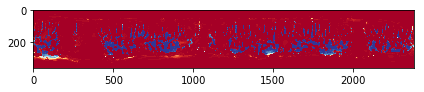

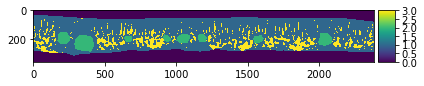

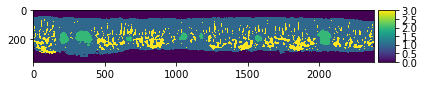

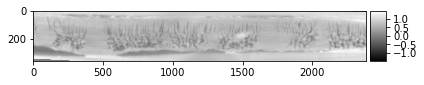

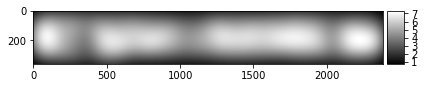

IndexError: index 1 is out of bounds for axis 0 with size 1

In [29]:
# Plot images of class probabilities, predicted classes, observed classes, and feature layer of interest
%matplotlib inline
for i in range(0,prediction_transverse_imgs.shape[2]):
    io.imshow(prediction_transverse_prob_imgs[i,:,:,3], cmap="RdYlBu")
    io.show()
    io.imshow(observed_transverse_imgs[i,:,:])
    io.show()
    io.imshow(prediction_transverse_imgs[i,:,:])
    io.show()
    io.imshow(phaserec_stack[260,:,:], cmap="gray")
    io.show()
    io.imshow(FL_transverse_imgs[0,:,:,26], cmap="gray")
    io.show()

### Predict all slices in 3D microCT stack

In [42]:
# Predict all slices in 3D microCT stack
RFPredictCTStack_out = RFLeafSeg.RFPredictCTStack(rf_transverse,gridrec_stack, phaserec_stack, LocalThickness_CellVeins,"transverse")

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: 

In [102]:
# Calculate accuracy
test_slices = (99,160,248)
label_slices = (1,2,3)

# Generate confusion matrix
confusion_matrix = pd.crosstab(RFPredictCTStack_out[test_slices,:,:].ravel(order="F"),
                               label_stack[label_slices,:,:].ravel(order="F"),
                               rownames=['Actual'], colnames=['Predicted'])

# Generate normalized confusion matrix
confusion_matrix_norm = pd.crosstab(RFPredictCTStack_out[test_slices,:,:].ravel(order="F"),
                               label_stack[label_slices,:,:].ravel(order="F"),
                               rownames=['Actual'], colnames=['Predicted'])

# Total accuracy
print(np.diag(confusion_matrix).sum()/RFPredictCTStack_out[test_slices,:,:].sum())

# Class precision
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,1), "precision")

# Class recall
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,0), "recall")

0.948614853886
(Predicted
0      0.814424
100    0.953067
200    0.626939
255    0.994903
dtype: float64, 'recall')
(Actual
0.0    0.981750
1.0    0.855162
2.0    0.625278
3.0    0.964723
dtype: float64, 'precision')
Predicted
0      0.445147
100    0.450732
200    0.313054
255    0.489790
dtype: float64


In [44]:
# Save classified stack
io.imsave('Vitis_champ_Predicted.tif',img_as_int(RFPredictCTStack_out/4))

/Users/masonearles/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to int16
  .format(dtypeobj_in, dtypeobj_out))
